In [1]:
import seaborn as sns
import os
import cv2
import random
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline

2025-07-01 07:32:30.950425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751355151.105165      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751355151.150353      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_dir = Path('../input/deepfake-image-detection/train-20250112T065955Z-001/train')
classes = ['real', 'fake']

filepaths = []
labels = []

for label in classes:
    class_dir = base_dir / label
    image_files = class_dir.glob('*')

    for file in image_files:
        if file.is_file():
            filepaths.append(str(file))
            labels.append(label)

In [3]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')

In [4]:
df=pd.concat([Files,Label], axis=1)

In [5]:
df.sample(10)

filepaths labels
92   ../input/deepfake-image-detection/train-202501...   real
358  ../input/deepfake-image-detection/train-202501...   fake
253  ../input/deepfake-image-detection/train-202501...   real
469  ../input/deepfake-image-detection/train-202501...   fake
198  ../input/deepfake-image-detection/train-202501...   real
434  ../input/deepfake-image-detection/train-202501...   fake
301  ../input/deepfake-image-detection/train-202501...   real
214  ../input/deepfake-image-detection/train-202501...   real
419  ../input/deepfake-image-detection/train-202501...   fake
403  ../input/deepfake-image-detection/train-202501...   fake

In [6]:
def sample_images(label, df, n=5):
    """
    Displays n images in a single row from the specified label.
    
    Parameters:
    - label (str): 'real' or 'fake'
    - df (pd.DataFrame): DataFrame with 'filepaths' and 'labels'
    - n (int): Number of images to display (default is 5)
    """
    subset = df[df['labels'] == label]
    
    if subset.empty:
        print(f"No images found with label: {label}")
        return

    sample_files = subset.sample(min(n, len(subset)))['filepaths'].tolist()

    plt.figure(figsize=(15, 5))
    for i, file_path in enumerate(sample_files):
        try:
            img = Image.open(file_path)
            plt.subplot(1, n, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{label.capitalize()}")
        except Exception as e:
            print(f"Error loading image {file_path}: {e}")
    plt.tight_layout()
    plt.show()

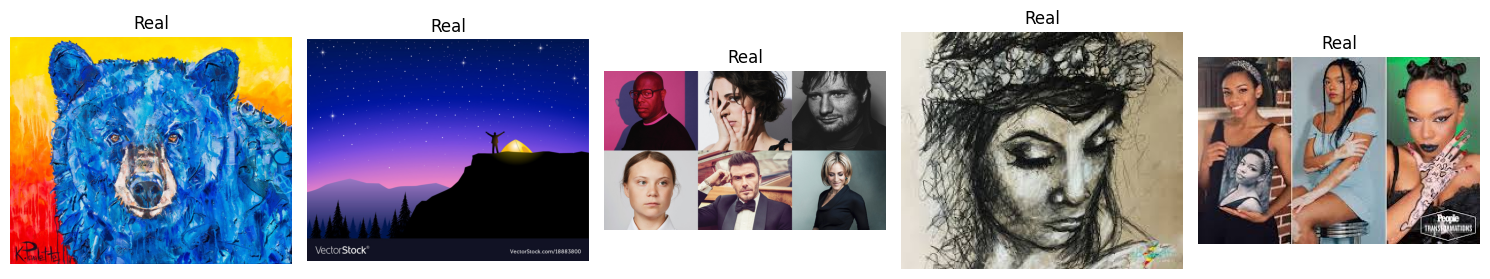

In [9]:
sample_images('real', df)

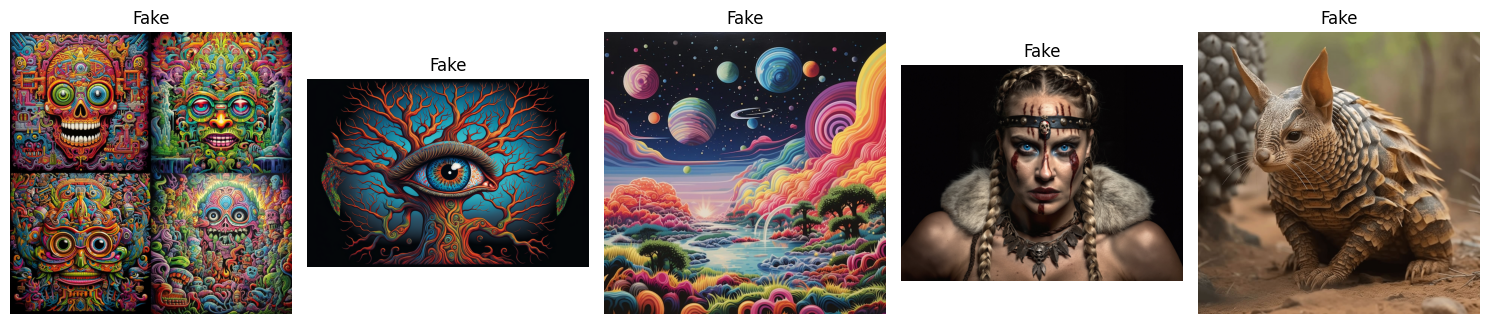

In [10]:
sample_images('fake', df)

In [11]:
def label_distribution(df):
    """
    Plots a bar chart and a pie chart showing the distribution of labels.
    Bar chart shows counts with text on top of bars.
    Pie chart shows percentages.
    """
    label_counts = df['labels'].value_counts()
    labels = label_counts.index
    counts = label_counts.values
    percentages = label_counts / label_counts.sum() * 100

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Bar plot
    axes[0].bar(labels, counts, color=['skyblue', 'salmon'])
    axes[0].set_title('Label Counts')
    axes[0].set_ylabel('Count')
    
    for i, count in enumerate(counts):
        axes[0].text(i, count + 1, str(count), ha='center', va='bottom', fontsize=10)

    axes[1].pie(
        counts,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=['skyblue', 'salmon']
    )
    axes[1].set_title('Label Distribution (%)')

    plt.tight_layout()
    plt.show()

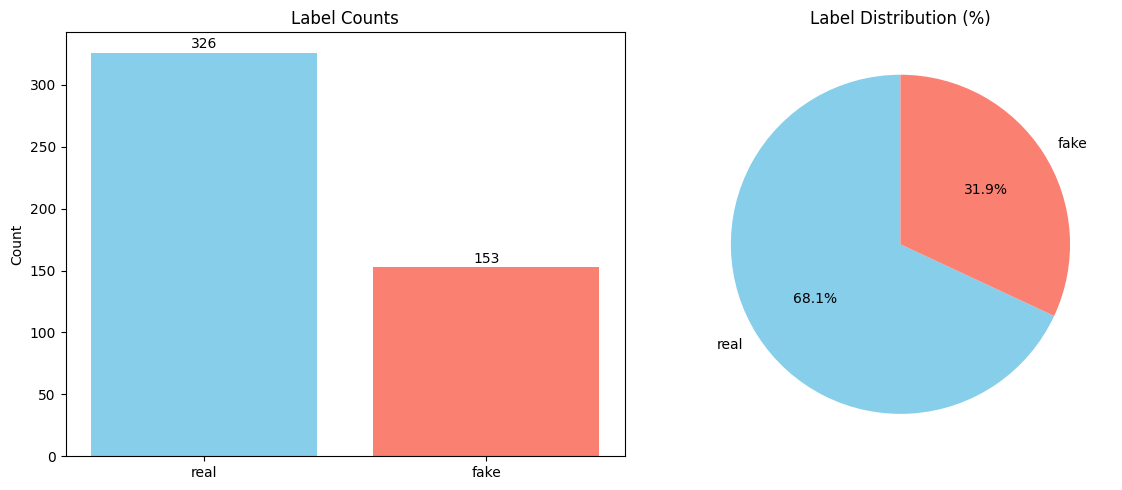

In [12]:
label_distribution(df)

In [13]:
image_size = 224
images = []
processed_labels = []

for path, label in zip(df['filepaths'], df['labels']):
    img = cv2.imread(path)  # Load as BGR
    if img is None:
        print(f"Warning: Could not read image {path}")
        continue
    
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)
    processed_labels.append(label)

libpng warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


In [14]:
images[:1]

[array([[[27, 27, 27],
         [26, 26, 26],
         [25, 25, 25],
         ...,
         [28, 28, 28],
         [27, 27, 27],
         [27, 27, 27]],
 
        [[27, 27, 27],
         [26, 26, 26],
         [25, 25, 25],
         ...,
         [28, 28, 28],
         [28, 28, 28],
         [27, 27, 27]],
 
        [[27, 27, 27],
         [26, 26, 26],
         [25, 25, 25],
         ...,
         [29, 29, 29],
         [28, 28, 28],
         [28, 28, 28]],
 
        ...,
 
        [[23, 23, 23],
         [23, 23, 23],
         [23, 23, 23],
         ...,
         [23, 23, 23],
         [23, 23, 23],
         [23, 23, 23]],
 
        [[23, 23, 23],
         [23, 23, 23],
         [23, 23, 23],
         ...,
         [23, 23, 23],
         [23, 23, 23],
         [23, 23, 23]],
 
        [[23, 23, 23],
         [23, 23, 23],
         [23, 23, 23],
         ...,
         [23, 23, 23],
         [23, 23, 23],
         [23, 23, 23]]], dtype=uint8)]

In [15]:
processed_labels[:5]

['real', 'real', 'real', 'real', 'real']

In [16]:
x = np.array(images, dtype='float32') / 255.0

In [17]:
x.shape

(479, 224, 224, 3)

In [18]:
le = LabelEncoder()
y_encoded = le.fit_transform(processed_labels)
y = to_categorical(y_encoded, num_classes=2)

In [19]:
y.shape

(479, 2)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, shuffle = True, random_state=42)

In [21]:
x_train.shape

(407, 224, 224, 3)

In [22]:
y_train.shape

(407, 2)

In [23]:
import tensorflow.keras
from tensorflow.keras import backend as K
from keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.layers import Dropout,BatchNormalization,Input
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.utils import class_weight

In [24]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(y_encoded),
                                                  y=y_encoded)
class_weights_dict = dict(enumerate(class_weights))

In [25]:
epochs = 10
input_shape = (225, 225, 3)

In [41]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 225, 225, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 225, 225, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 401408)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │     102,760,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 102,989,634 (392.87 MB)

 Trainable params: 102,988,098 (392.87 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1, width_shift_range=0.1,
                             height_shift_range=0.1, horizontal_flip=True)

In [43]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=epochs, validation_data=(x_test, y_test), 
                    class_weight=class_weights_dict)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 523ms/step - accuracy: 0.4910 - loss: 1.3431 - val_accuracy: 0.6944 - val_loss: 0.8310
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 316ms/step - accuracy: 0.5550 - loss: 0.7613 - val_accuracy: 0.6944 - val_loss: 0.7454
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 323ms/step - accuracy: 0.6098 - loss: 0.7556 - val_accuracy: 0.6944 - val_loss: 0.6198
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 309ms/step - accuracy: 0.6431 - loss: 0.6376 - val_accuracy: 0.7083 - val_loss: 0.5854
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 335ms/step - accuracy: 0.6634 - loss: 0.6250 - val_accuracy: 0.7083 - val_loss: 0.6019
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 326ms/step - accuracy: 0.6059 - loss: 0.7191 - val_accuracy: 0.7222 - val_loss: 0.6152
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 311ms/step - accuracy: 0.6834 - loss: 0.5679 - val_accuracy: 0.7222 - val_loss: 0.6067
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 343ms/step - accuracy: 0.6566 - loss: 0.6223 - val_accuracy: 0

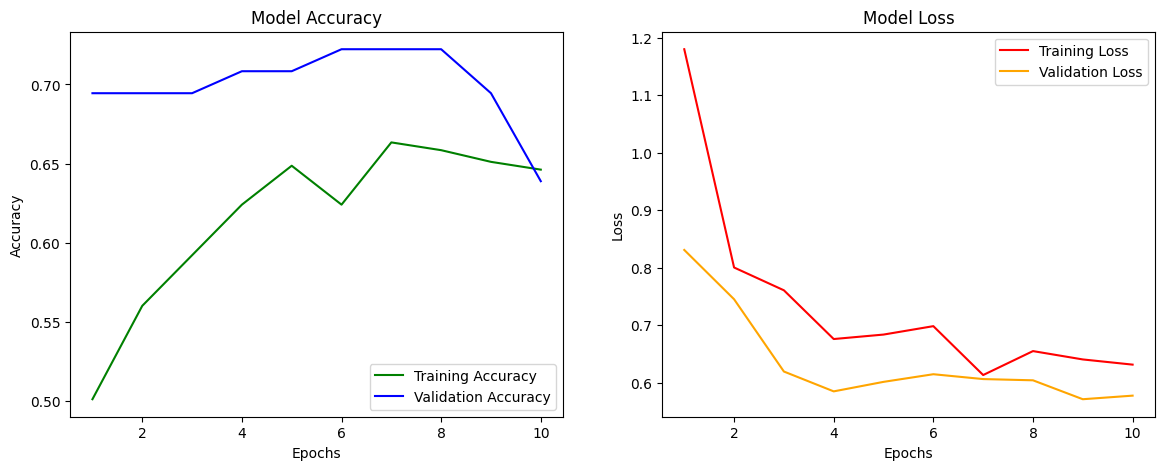

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='green')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


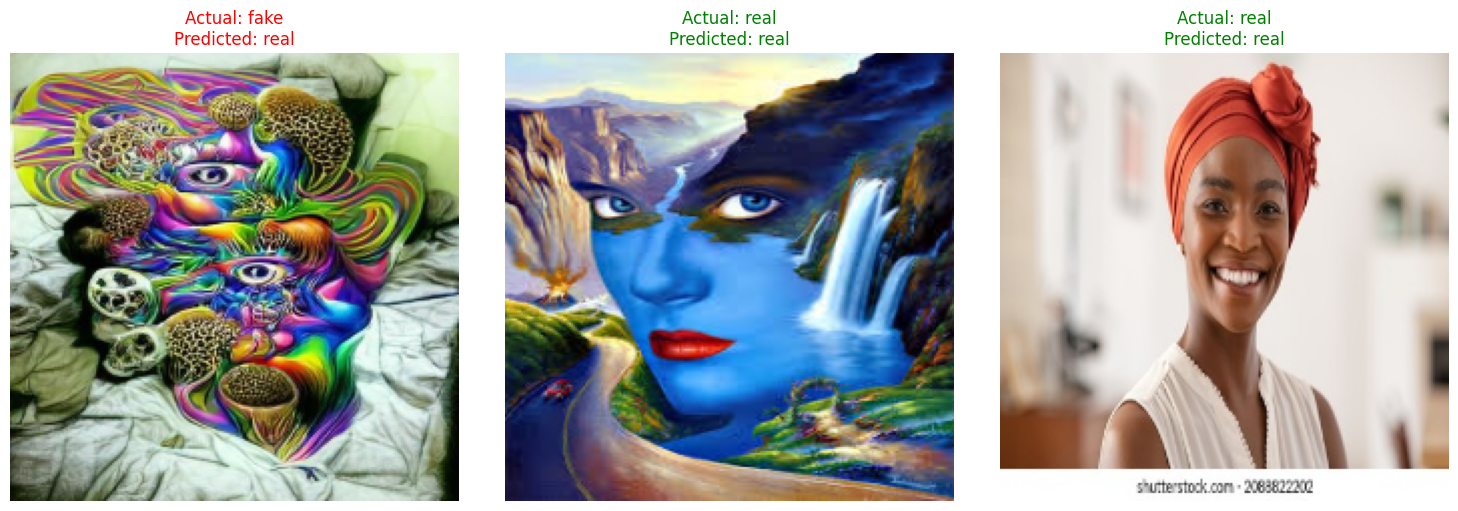

In [46]:
label_map = {i: label for i, label in enumerate(le.classes_)}

random_indices = random.sample(range(x_test.shape[0]), 3)
sample_images = x_test[random_indices]
sample_labels = y_test[random_indices]

predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(sample_labels, axis=1)

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(sample_images[i])
    plt.axis('off')
    plt.title(
        f"Actual: {label_map[true_classes[i]]}\nPredicted: {label_map[predicted_classes[i]]}",
        color='green' if predicted_classes[i] == true_classes[i] else 'red')

plt.tight_layout()
plt.show()

In [47]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

In [50]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False 

model = Sequential([base_model, GlobalAveragePooling2D(),
                    Dense(256, activation='relu'), Dropout(0.5),
                    Dense(2, activation='softmax')])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,846,530 (56.64 MB)

 Trainable params: 131,842 (515.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [51]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=epochs, validation_data=(x_test, y_test), 
                    class_weight=class_weights_dict)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 891ms/step - accuracy: 0.4448 - loss: 0.7355 - val_accuracy: 0.4028 - val_loss: 0.7035
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 356ms/step - accuracy: 0.4701 - loss: 0.7457 - val_accuracy: 0.4444 - val_loss: 0.7059
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 363ms/step - accuracy: 0.4519 - loss: 0.7562 - val_accuracy: 0.5556 - val_loss: 0.6954
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 339ms/step - accuracy: 0.5216 - loss: 0.7209 - val_accuracy: 0.5833 - val_loss: 0.6923
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 342ms/step - accuracy: 0.4903 - loss: 0.7098 - val_accuracy: 0.6806 - val_loss: 0.6836
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 357ms/step - accuracy: 0.5571 - loss: 0.7137 - val_accuracy: 0.6944 - val_loss: 0.6800
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 337ms/step - accuracy: 0.5521 - loss: 0.6940 - val_accuracy: 0.6806 - val_loss: 0.6765
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 374ms/step - accuracy: 0.5817 - loss: 0.6802 - val_accuracy: 0

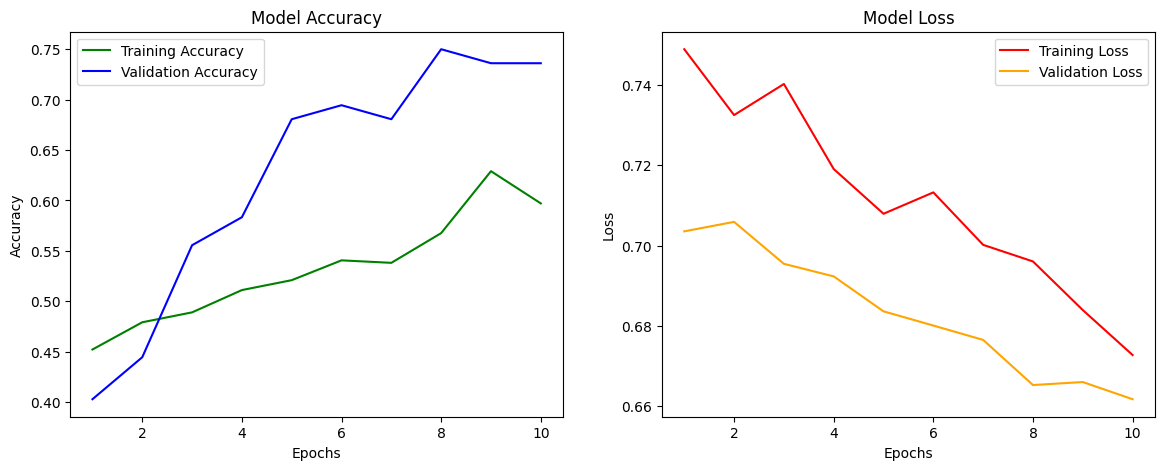

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='green')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


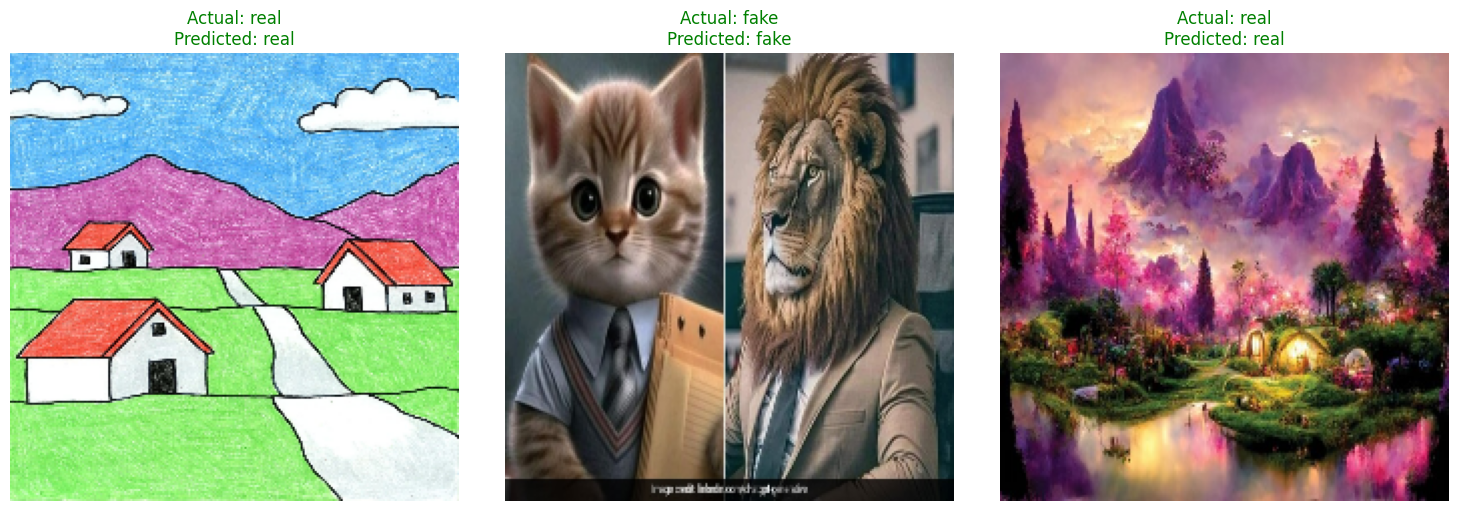

In [53]:
label_map = {i: label for i, label in enumerate(le.classes_)}

random_indices = random.sample(range(x_test.shape[0]), 3)
sample_images = x_test[random_indices]
sample_labels = y_test[random_indices]

predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(sample_labels, axis=1)

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(sample_images[i])
    plt.axis('off')
    plt.title(
        f"Actual: {label_map[true_classes[i]]}\nPredicted: {label_map[predicted_classes[i]]}",
        color='green' if predicted_classes[i] == true_classes[i] else 'red')

plt.tight_layout()
plt.show()

In [28]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D

In [29]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential([base_model, GlobalAveragePooling2D(), 
                    Dense(256, activation='relu'), Dropout(0.5), 
                    Dense(2, activation='softmax')])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,386,538 (81.58 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [32]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=epochs, validation_data=(x_test, y_test), 
                    class_weight=class_weights_dict)

Epoch 1/10


I0000 00:00:1751355749.754717     107 service.cc:148] XLA service 0x7d38f800e840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751355749.755538     107 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751355749.755561     107 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751355750.727600     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/13 ━━━━━━━━━━━━━━━━━━━━ 3:02 15s/step - accuracy: 0.3750 - loss: 0.6955

I0000 00:00:1751355758.515678     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4289 - loss: 0.7425 - val_accuracy: 0.6806 - val_loss: 0.6703
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 332ms/step - accuracy: 0.5638 - loss: 0.6860 - val_accuracy: 0.6944 - val_loss: 0.6350
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 313ms/step - accuracy: 0.6600 - loss: 0.6432 - val_accuracy: 0.6667 - val_loss: 0.6453
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 320ms/step - accuracy: 0.6561 - loss: 0.6133 - val_accuracy: 0.7222 - val_loss: 0.5979
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 314ms/step - accuracy: 0.7694 - loss: 0.5977 - val_accuracy: 0.7222 - val_loss: 0.5920
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 309ms/step - accuracy: 0.7495 - loss: 0.5752 - val_accuracy: 0.7222 - val_loss: 0.5850
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step - accuracy: 0.7728 - loss: 0.5745 - val_accuracy: 0.7361 - val_loss: 0.5678
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 312ms/step - accuracy: 0.8057 - loss: 0.5327 - val_accuracy: 0.7639 - val_lo

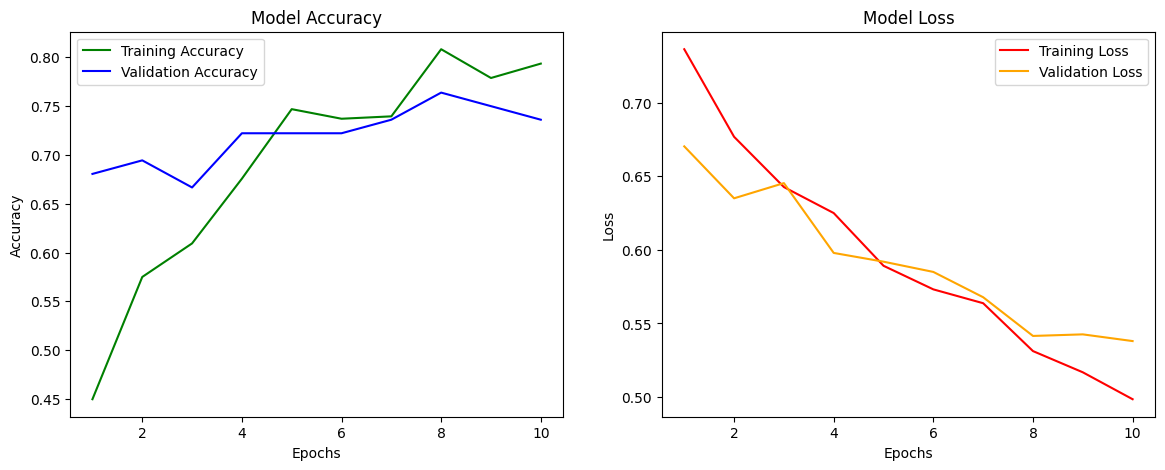

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='green')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


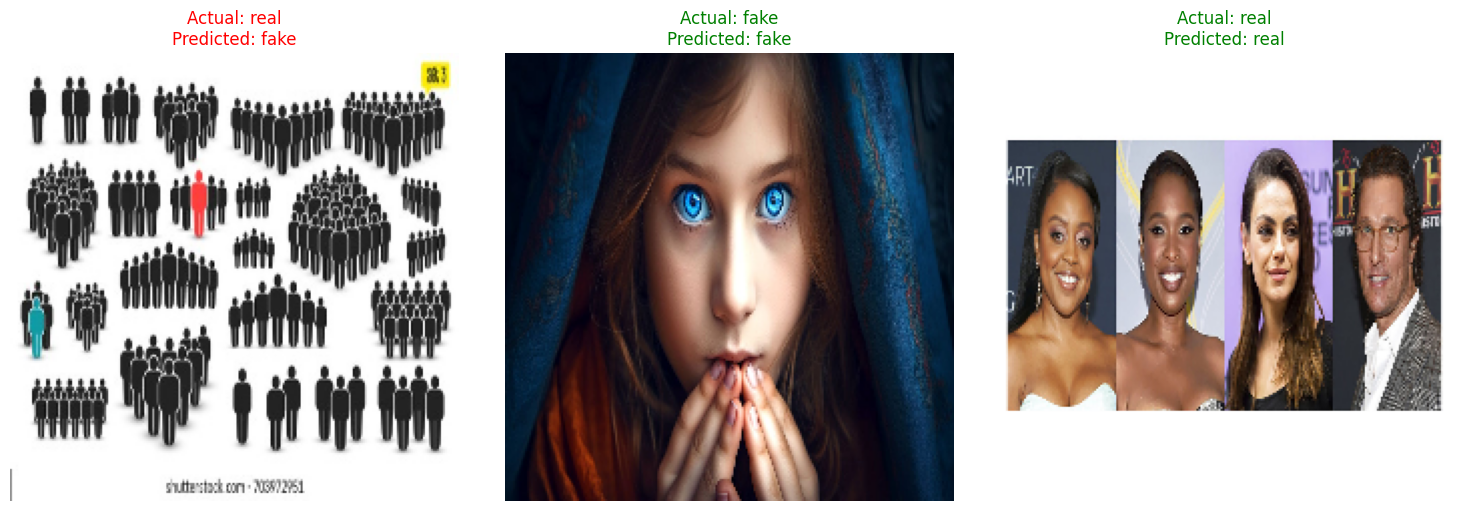

In [35]:
label_map = {i: label for i, label in enumerate(le.classes_)}

random_indices = random.sample(range(x_test.shape[0]), 3)
sample_images = x_test[random_indices]
sample_labels = y_test[random_indices]

predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(sample_labels, axis=1)

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(sample_images[i])
    plt.axis('off')
    plt.title(
        f"Actual: {label_map[true_classes[i]]}\nPredicted: {label_map[predicted_classes[i]]}",
        color='green' if predicted_classes[i] == true_classes[i] else 'red')

plt.tight_layout()
plt.show()